# Pet Dataset Segmentation
## Machine Learning data mining final project
### __Team members:__ Vedanshi Shah, Vedant Bhagat, Sid Mallareddygari

In [2]:
# imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from vit_keras import vit, utils
from tensorflow import keras
from tensorflow.keras import layers

2023-04-13 00:58:25.919821: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'vit_keras'

# Set up
#### Describe the dataset, including its basic statistics. 

Create a dataframe with the compiled information

In [5]:
# specify the path of the image folder
folder_path = 'data/images/'

# read all files in the folder with extension '.jpg'
image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]

df = pd.DataFrame(columns=['image', 'label', 'breed'])
rows = []

for image_path in image_paths:
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: could not read image at {image_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert color from BGR (used by OpenCV) to RGB
    img_array = np.array(img)

    # image path get name
    filename = image_path.split('/')[-1]
    breed = filename.rsplit('_', 1)
    breed = breed[0]
    
    # breed is cat if the first char of the filename is Upper case
    if filename[0].isupper():
        label = 'cat'
    else:
        label = 'dog'

    row = {'image': img, 'label': label, 'breed': breed, 'filename': filename}
    rows.append(row)
    
df = pd.DataFrame(rows)

Error: could not read image at data/images/Egyptian_Mau_167.jpg


Corrupt JPEG data: premature end of data segment


Error: could not read image at data/images/Egyptian_Mau_177.jpg
Error: could not read image at data/images/Egyptian_Mau_139.jpg


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Error: could not read image at data/images/Abyssinian_34.jpg
Error: could not read image at data/images/Egyptian_Mau_191.jpg
Error: could not read image at data/images/Egyptian_Mau_145.jpg


In [6]:
# making sure we get the desired information
# with the image itself, the label, the breed and the filename
df.head()

,image,label,breed,filename
0,"[[[56, 18, 15], [54, 16, 13], [55, 17, 14], [5...",dog,pug,pug_52.jpg
1,"[[[188, 190, 205], [190, 189, 205], [192, 191,...",dog,basset_hound,basset_hound_112.jpg
2,"[[[95, 78, 48], [96, 80, 44], [94, 74, 39], [8...",cat,Siamese,Siamese_193.jpg
3,"[[[56, 89, 8], [57, 90, 9], [54, 89, 7], [55, ...",dog,shiba_inu,shiba_inu_122.jpg
4,"[[[112, 84, 60], [127, 81, 66], [112, 82, 54],...",cat,Siamese,Siamese_53.jpg


Plot the basic statistics

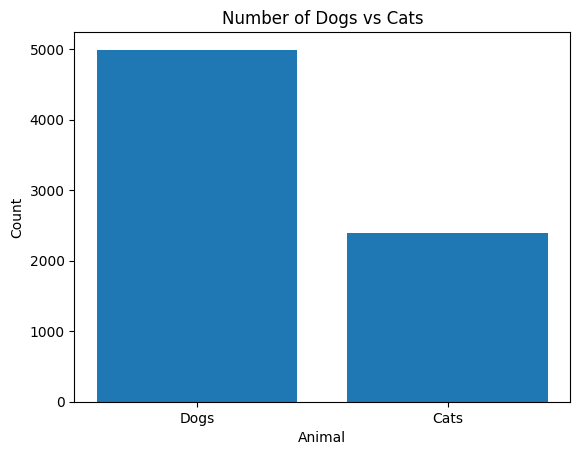

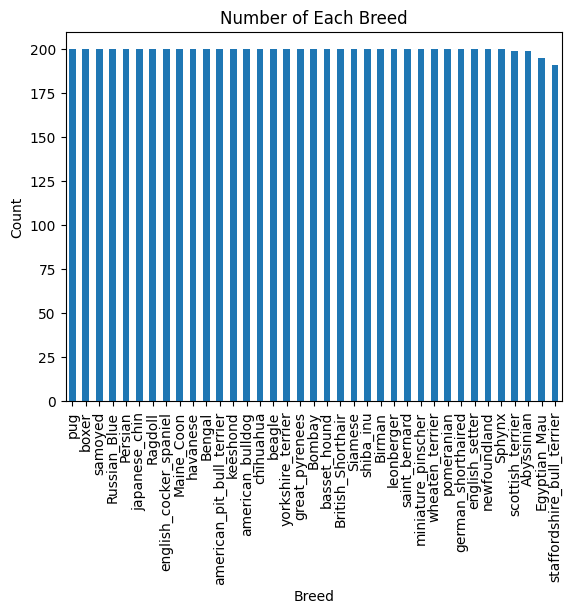

In [7]:
import matplotlib.pyplot as plt
# Count the number of dogs and cats
dog_count = (df['label'] == 'dog').sum()
cat_count = (df['label'] == 'cat').sum()

# Create a bar plot of the dog and cat counts
plt.bar(['Dogs', 'Cats'], [dog_count, cat_count])
plt.title('Number of Dogs vs Cats')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.show()

# Count the number of each breed
breed_counts = df['breed'].value_counts()

# Create a bar plot of the breed counts
breed_counts.plot(kind='bar')
plt.title('Number of Each Breed')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show()

In [8]:
df[['breed', 'label']].describe()

,breed,label
count,7384,7384
unique,37,2
top,pug,dog
freq,200,4990


Save to dataframe for ease of future use

In [9]:
# save the dataframe
df.to_csv('data.csv')

### Models

In [10]:
data = pd.read_csv('data.csv')

In [11]:
# making sure that we are not changing any of the original data
data = df.copy(deep=True)

# preprocess image data
data['image'] = data['image'].apply(lambda x: np.array(Image.fromarray(x).resize((224, 224))))
data['image'] = data['image'].apply(lambda x: x / 255.0)

In [12]:
# one-hot encode label
# data['label'] = data['label'].apply(lambda x: 1 if x == 'dog' else 0)
data = pd.get_dummies(data, columns=['label'])
# one-hot encode breed
data = pd.get_dummies(data, columns=['breed'])

In [13]:
# making sure that the data is one-hot-encoded
data.head()

,image,filename,label_cat,label_dog,breed_Abyssinian,breed_Bengal,breed_Birman,breed_Bombay,breed_British_Shorthair,breed_Egyptian_Mau,...,breed_newfoundland,breed_pomeranian,breed_pug,breed_saint_bernard,breed_samoyed,breed_scottish_terrier,breed_shiba_inu,breed_staffordshire_bull_terrier,breed_wheaten_terrier,breed_yorkshire_terrier
0,"[[[0.21176470588235294, 0.06274509803921569, 0...",pug_52.jpg,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"[[[0.7215686274509804, 0.7490196078431373, 0.8...",basset_hound_112.jpg,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[[[0.3686274509803922, 0.29411764705882354, 0....",Siamese_193.jpg,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[[[0.2235294117647059, 0.3568627450980392, 0.0...",shiba_inu_122.jpg,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,"[[[0.4627450980392157, 0.3333333333333333, 0.2...",Siamese_53.jpg,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# split data into train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)

# split train into train and validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

In [15]:
# add data/images/ to the filenames
train['filename'] = 'data/images/' + train['filename']
val['filename'] = 'data/images/' + val['filename']

In [16]:
# convert label_0 and label_1 to label_cat and label_dog
train = train.rename(columns={'label_0': 'label_cat', 'label_1': 'label_dog'})
val = val.rename(columns={'label_0': 'label_cat', 'label_1': 'label_dog'})

In [17]:
# train the model
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col='filename',
    y_col=['label_cat', 'label_dog'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    val,
    x_col='filename',
    y_col=['label_cat', 'label_dog'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

Found 4725 validated image filenames.
Found 1182 validated image filenames.


In [18]:
# train the model with the breeds
train_datagen_breed = ImageDataGenerator(rescale=1./255)
val_datagen_breed = ImageDataGenerator(rescale=1./255)

train_generator_breed = train_datagen_breed.flow_from_dataframe(
    train,
    x_col='filename',
    y_col=[col for col in train.columns if col.startswith('breed_')],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

val_generator_breed = val_datagen_breed.flow_from_dataframe(
    val,
    x_col='filename',
    y_col=[col for col in val.columns if col.startswith('breed_')],
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

Found 4725 validated image filenames.
Found 1182 validated image filenames.


total epochs to run the models for

In [19]:
epoch = 10

Convolutional neural network

In [20]:
# define the convolutional neural network model

# adding the feature extraction and classification layers
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

# compile the model
model_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
# fit the model
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=epoch,
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=epoch
)

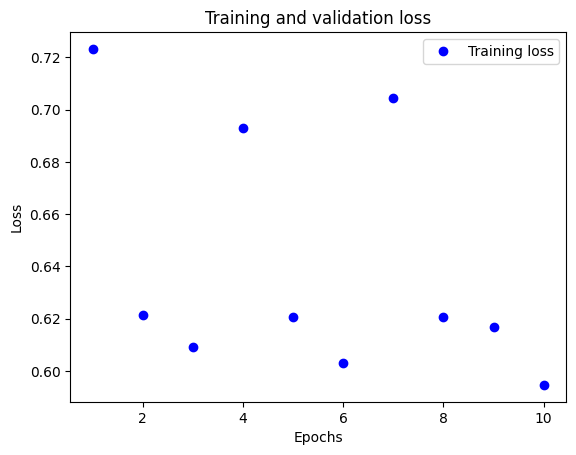

In [ ]:
# plot the training and validation loss
loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

epochs = range(1, len(loss_cnn) + 1)

plt.plot(epochs, loss_cnn, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

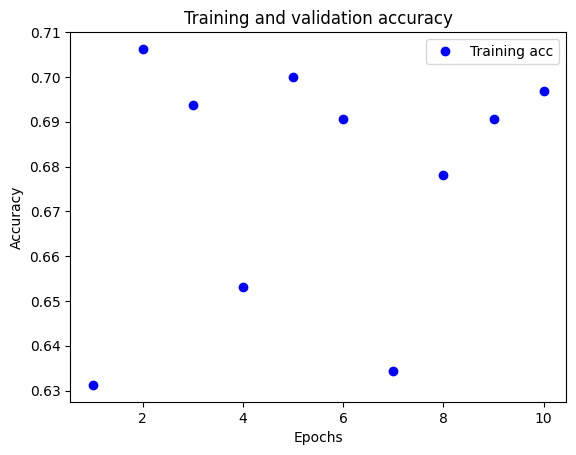

In [ ]:
# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_cnn.history['acc'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# define the convolutional neural network model

# adding the feature extraction and classification layers
model_cnn_breed = Sequential()
model_cnn_breed.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn_breed.add(MaxPooling2D((2, 2)))
model_cnn_breed.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_breed.add(MaxPooling2D((2, 2)))
model_cnn_breed.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_breed.add(MaxPooling2D((2, 2)))
model_cnn_breed.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_breed.add(MaxPooling2D((2, 2)))
model_cnn_breed.add(Flatten())
model_cnn_breed.add(Dense(512, activation='relu'))
model_cnn_breed.add(Dense(37, activation='softmax'))

# compile the model with multi classification loss function
model_cnn_breed.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model_cnn_breed.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

In [27]:
# fit the model
history_cnn_breed = model_cnn_breed.fit(
    train_generator_breed,
    steps_per_epoch=epoch,
    epochs=epoch,
    validation_data=val_generator_breed,
    validation_steps=epoch
)

Epoch 1/10


2023-04-13 01:03:45.667510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 3.8084 - acc: 0.0312

2023-04-13 01:04:09.283031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 30s 3s/step - loss: 3.8084 - acc: 0.0312 - val_loss: 3.6199 - val_acc: 0.0250
Epoch 2/10
10/10 [==============================] - 28s 3s/step - loss: 3.6251 - acc: 0.0250 - val_loss: 3.6119 - val_acc: 0.0281
Epoch 3/10
10/10 [==============================] - 31s 3s/step - loss: 3.6097 - acc: 0.0219 - val_loss: 3.6149 - val_acc: 0.0094
Epoch 4/10
10/10 [==============================] - 29s 3s/step - loss: 3.6119 - acc: 0.0500 - val_loss: 3.6059 - val_acc: 0.0344
Epoch 5/10
10/10 [==============================] - 35s 4s/step - loss: 3.6114 - acc: 0.0406 - val_loss: 3.6099 - val_acc: 0.0250
Epoch 6/10
10/10 [==============================] - 44s 4s/step - loss: 3.6150 - acc: 0.0312 - val_loss: 3.6034 - val_acc: 0.0656
Epoch 7/10
10/10 [==============================] - 48s 5s/step - loss: 3.6049 - acc: 0.0219 - val_loss: 3.6082 - val_acc: 0.0219
Epoch 8/10
10/10 [==============================] - 49s 5s/step - loss: 3.6172 - acc: 0.0356 - val_lo

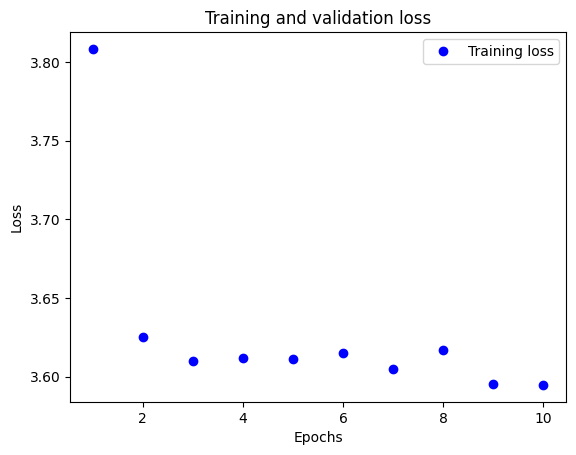

In [29]:
# plot the training and validation loss
loss_cnn_breed = history_cnn_breed.history['loss']
val_loss_cnn_breed = history_cnn_breed.history['val_loss']

epochs = range(1, len(loss_cnn_breed) + 1)

plt.plot(epochs, loss_cnn_breed, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

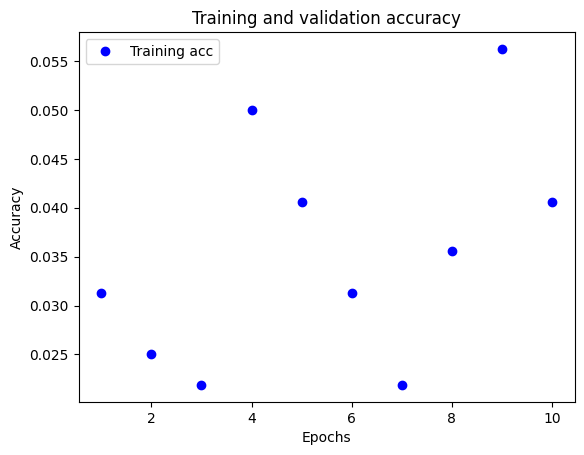

In [30]:
# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_cnn.history['acc'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Resnet models

In [ ]:
import ssl

# if you get errors you can run this 
ssl._create_default_https_context = ssl._create_unverified_context

2023-04-10 01:21:40.748518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/4
10/10 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.5875

2023-04-10 01:22:36.250979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 101s 10s/step - loss: 0.9804 - accuracy: 0.5875 - val_loss: 1.0784 - val_accuracy: 0.6062
Epoch 2/4
10/10 [==============================] - 75s 8s/step - loss: 0.8817 - accuracy: 0.6156 - val_loss: 0.6458 - val_accuracy: 0.6562
Epoch 3/4
10/10 [==============================] - 76s 8s/step - loss: 0.6579 - accuracy: 0.6570 - val_loss: 0.6197 - val_accuracy: 0.6625
Epoch 4/4
10/10 [==============================] - 80s 8s/step - loss: 0.6692 - accuracy: 0.6125 - val_loss: 0.6105 - val_accuracy: 0.6469


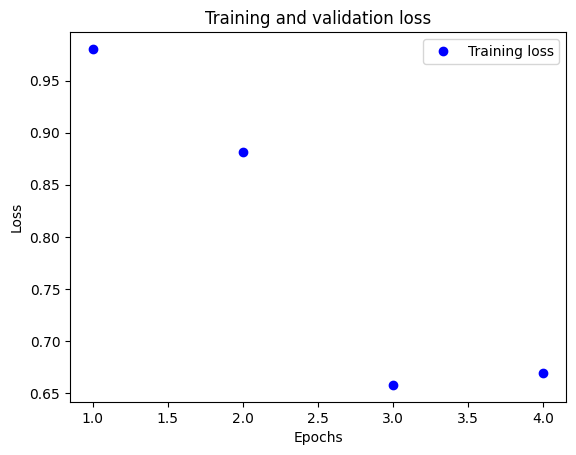

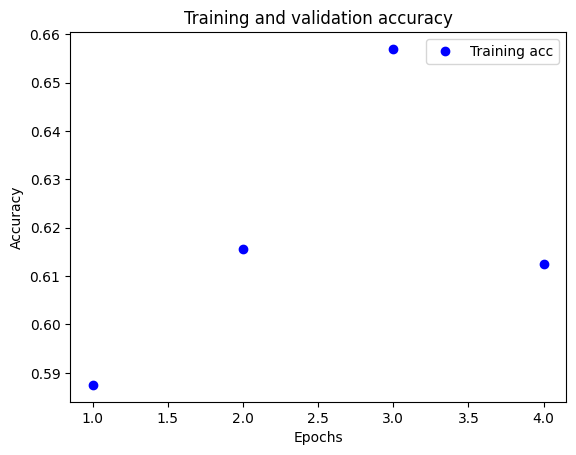

In [ ]:
# Load the pre-trained ResNet50 model
resnet_50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained ResNet50 model
for layer in resnet_50.layers:
    layer.trainable = False

# Add a new classification layer
x = resnet_50.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions_50 = tf.keras.layers.Dense(2, activation='softmax')(x)
model_50 = tf.keras.models.Model(inputs=resnet_50.input, outputs=predictions_50)

# Compile the model
model_50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_50 = model_50.fit(
    train_generator,
    steps_per_epoch=epoch,
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=epoch
)

# plot the training and validation loss
loss_50 = history_50.history['loss']
val_loss_50 = history_50.history['val_loss']

epochs = range(1, len(loss_50) + 1)

plt.plot(epochs, loss_50, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_50.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_50.summary()

Epoch 1/10


2023-04-13 01:13:04.792951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 3.9342 - accuracy: 0.0219

2023-04-13 01:13:51.582834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 95s 9s/step - loss: 3.9342 - accuracy: 0.0219 - val_loss: 3.6609 - val_accuracy: 0.0281
Epoch 2/10
10/10 [==============================] - 118s 12s/step - loss: 3.7255 - accuracy: 0.0188 - val_loss: 3.6687 - val_accuracy: 0.0188
Epoch 3/10
10/10 [==============================] - 103s 11s/step - loss: 3.7047 - accuracy: 0.0281 - val_loss: 3.6401 - val_accuracy: 0.0188
Epoch 4/10
10/10 [==============================] - 77s 8s/step - loss: 3.6305 - accuracy: 0.0375 - val_loss: 3.6095 - val_accuracy: 0.0219
Epoch 5/10
10/10 [==============================] - 97s 10s/step - loss: 3.6277 - accuracy: 0.0281 - val_loss: 3.6095 - val_accuracy: 0.0156
Epoch 6/10
10/10 [==============================] - 93s 10s/step - loss: 3.6170 - accuracy: 0.0219 - val_loss: 3.6091 - val_accuracy: 0.0344
Epoch 7/10
10/10 [==============================] - 94s 10s/step - loss: 3.6078 - accuracy: 0.0312 - val_loss: 3.6118 - val_accuracy: 0.0469
Epoch 8/10
10/10 [======

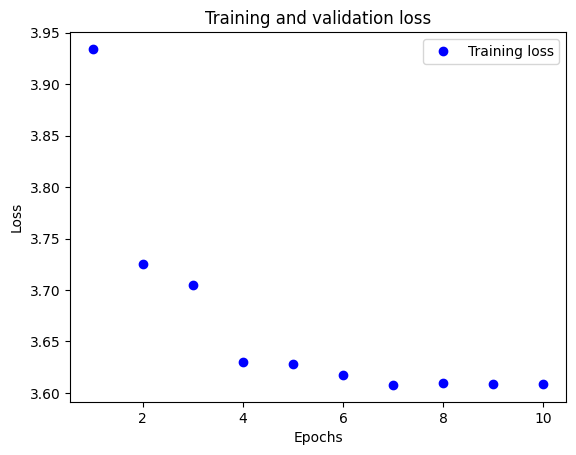

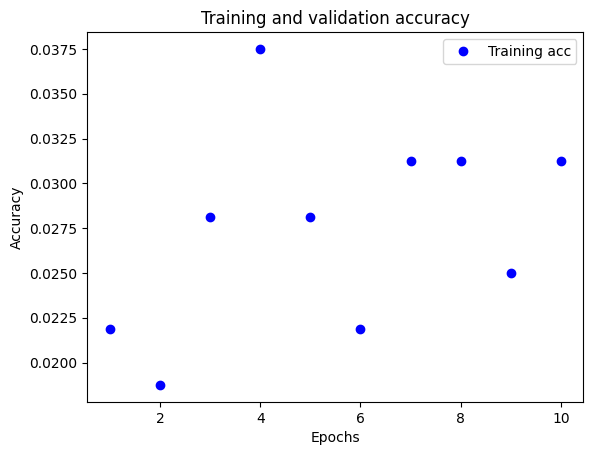

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [31]:
# Load the pre-trained ResNet50 model with the 37 classes of breeds
resnet_50_breed = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained ResNet50 model
for layer in resnet_50_breed.layers:
    layer.trainable = False

# Add a new classification layer
x = resnet_50_breed.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions_50_breed = tf.keras.layers.Dense(37, activation='softmax')(x)
model_50_breed = tf.keras.models.Model(inputs=resnet_50_breed.input, outputs=predictions_50_breed)

# Compile the model
model_50_breed.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_50_breed = model_50_breed.fit(
    train_generator_breed,
    steps_per_epoch=epoch,
    epochs=epoch,
    validation_data=val_generator_breed,
    validation_steps=epoch
)

# plot the training and validation loss
loss_50_breed = history_50_breed.history['loss']
val_loss_50_breed = history_50_breed.history['val_loss']

epochs = range(1, len(loss_50_breed) + 1)

plt.plot(epochs, loss_50_breed, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_50_breed.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_50_breed.summary()

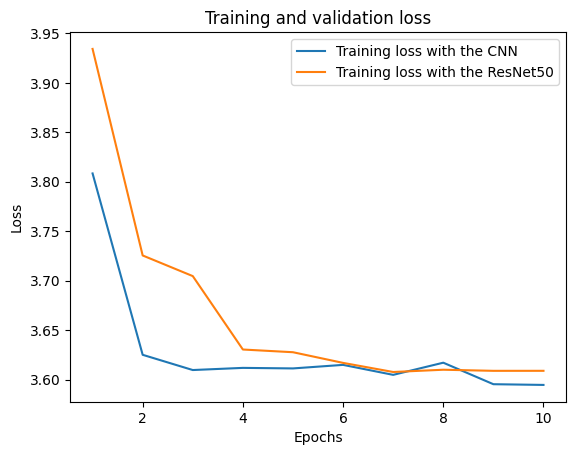

In [35]:
# Load the pre-trained ResNet50 model with the 37 classes of breeds
plt.plot(epochs, loss_cnn, label='Training loss with the CNN')
plt.plot(epochs, loss_50, label='Training loss with the ResNet50')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

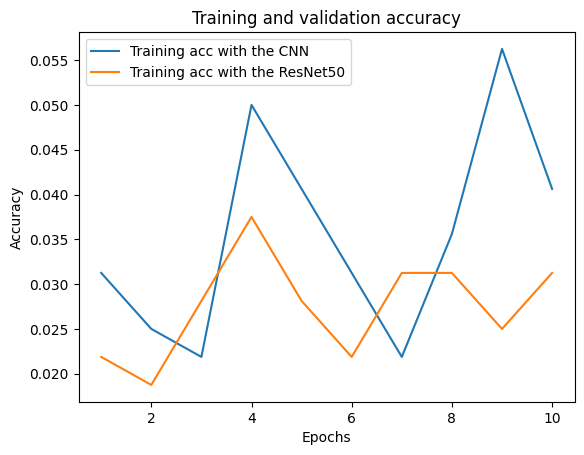

In [38]:
# plot the training and validation accuracy
plt.plot(epochs, history_cnn.history['acc'], label='Training acc with the CNN')
plt.plot(epochs, history_50.history['accuracy'], label='Training acc with the ResNet50')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load the pre-trained ResNet50 model with the 37 classes of breeds
plt.plot(epochs, loss_cnn_breed, 'bo', label='Training loss')
plt.plot(epochs, loss_50_breed, 'b', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.plot(epochs, history_cnn_breed.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_50_breed.history['accuracy'], 'b', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/4


2023-04-10 01:27:38.980409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.6375

2023-04-10 01:28:51.862989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 155s 15s/step - loss: 0.6749 - accuracy: 0.6375 - val_loss: 0.6530 - val_accuracy: 0.6750
Epoch 2/4
10/10 [==============================] - 162s 17s/step - loss: 0.6241 - accuracy: 0.6906 - val_loss: 0.5888 - val_accuracy: 0.7063
Epoch 3/4
10/10 [==============================] - 127s 13s/step - loss: 0.6337 - accuracy: 0.6500 - val_loss: 0.5881 - val_accuracy: 0.7000
Epoch 4/4
10/10 [==============================] - 123s 13s/step - loss: 0.6485 - accuracy: 0.6469 - val_loss: 0.5955 - val_accuracy: 0.6687


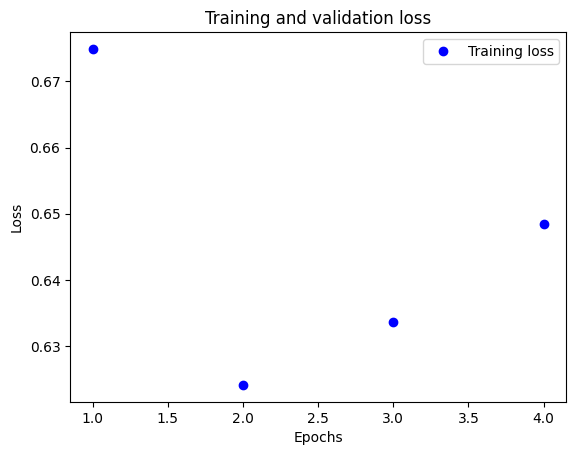

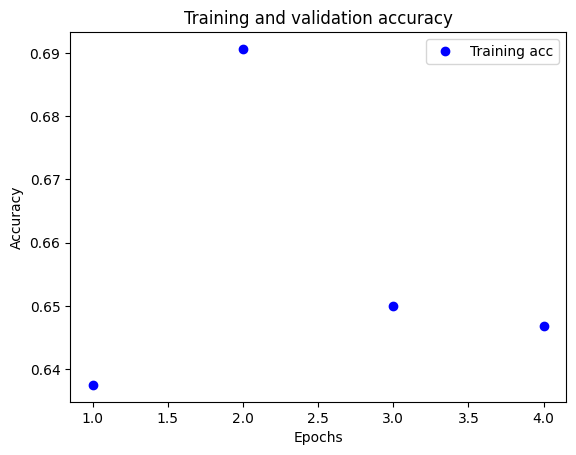

In [ ]:
# Load the pre-trained ResNet18 model
resnet_101 = tf.keras.applications.ResNet101 (weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained ResNet50 model
for layer in resnet_101.layers:
    layer.trainable = False

# Add a new classification layer
x = resnet_101.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions_101 = tf.keras.layers.Dense(2, activation='softmax')(x)
model_101 = tf.keras.models.Model(inputs=resnet_101.input, outputs=predictions_101)

# Compile the model
model_101.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_101= model_101.fit(
    train_generator,
    steps_per_epoch=epoch,
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=epoch
)

# plot the training and validation loss
loss_101 = history_101.history['loss']
val_loss_101 = history_101.history['val_loss']

epochs = range(1, len(loss_101) + 1)

plt.plot(epochs, loss_101, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_101.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_101.summary()

Epoch 1/4


2023-04-10 01:03:08.137311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - ETA: 0s - loss: 0.7709 - accuracy: 0.5844 

2023-04-10 01:06:13.682290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 362s 36s/step - loss: 0.7709 - accuracy: 0.5844 - val_loss: 0.6712 - val_accuracy: 0.6375
Epoch 2/4
10/10 [==============================] - 327s 34s/step - loss: 0.7669 - accuracy: 0.5969 - val_loss: 0.6379 - val_accuracy: 0.6812
Epoch 3/4
10/10 [==============================] - 205s 20s/step - loss: 0.6727 - accuracy: 0.6125 - val_loss: 0.6526 - val_accuracy: 0.6938
Epoch 4/4
10/10 [==============================] - 213s 23s/step - loss: 0.6483 - accuracy: 0.6875 - val_loss: 0.6071 - val_accuracy: 0.6719


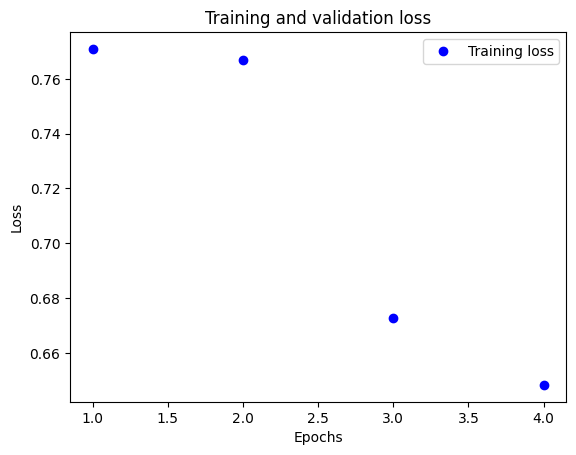

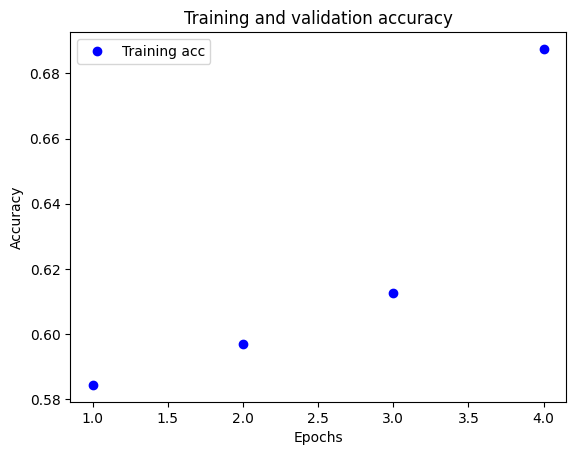

In [ ]:
# Load the pre-trained ResNet18 model
resnet_152 = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained ResNet50 model
for layer in resnet_152.layers:
    layer.trainable = False

# Add a new classification layer
x = resnet_152.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions_152 = tf.keras.layers.Dense(2, activation='softmax')(x)
model_152 = tf.keras.models.Model(inputs=resnet_152.input, outputs=predictions_152)

# Compile the model
model_152.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_152 = model_152.fit(
    train_generator,
    steps_per_epoch=epoch,
    epochs=epoch,
    validation_data=val_generator,
    validation_steps=epoch
)

# plot the training and validation loss
loss_152 = history_152.history['loss']
val_loss_152 = history_152.history['val_loss']

epochs = range(1, len(loss_152) + 1)

plt.plot(epochs, loss_152, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_152.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model_152.summary()
# runtime - 18 min 40 sec

compare all resnet models

seperately

In [ ]:
# compare the training and validation loss across the models
plt.clf()
plt.plot(epochs, loss_50, 'bo', label='Training loss')
plt.plot(epochs, loss_101, 'bo', label='Training loss')
plt.plot(epochs, loss_152, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# compare the training and validation accuracy across the models
plt.clf()
plt.plot(epochs, history_50.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_101.history['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_152.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

together

/var/folders/fn/gwc703ds68d7wjnsvd_65zwc0000gn/T/ipykernel_10808/3265908736.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_50, 'bo', label='Training loss 50', color='blue', linestyle='dashed')
/var/folders/fn/gwc703ds68d7wjnsvd_65zwc0000gn/T/ipykernel_10808/3265908736.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss_101, 'bo', label='Training loss 101', color='red', linestyle='dashed')
/var/folders/fn/gwc703ds68d7wjnsvd_65zwc0000gn/T/ipykernel_10808/3265908736.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss 152', color='green', linestyle='dashed')
/

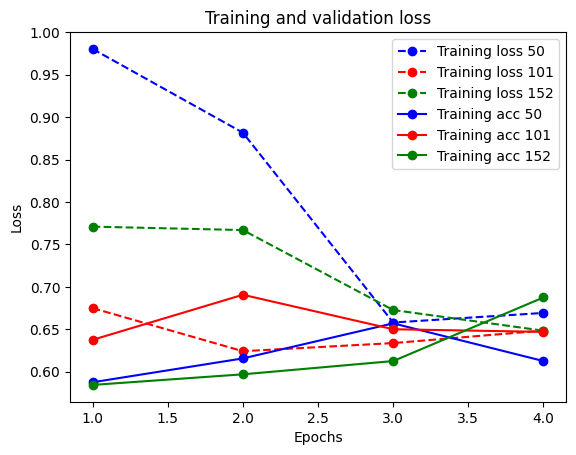

In [ ]:
# plot loss and accuracy for the three models
plt.clf()
plt.plot(epochs, loss_50, 'bo', label='Training loss 50', color='blue', linestyle='dashed')
plt.plot(epochs, loss_101, 'bo', label='Training loss 101', color='red', linestyle='dashed')
plt.plot(epochs, loss_152, 'bo', label='Training loss 152', color='green', linestyle='dashed')
plt.plot(epochs, history_50.history['accuracy'], 'bo', label='Training acc 50', color='blue', linestyle='solid')
plt.plot(epochs, history_101.history['accuracy'], 'bo', label='Training acc 101', color='red', linestyle='solid')
plt.plot(epochs, history_152.history['accuracy'], 'bo', label='Training acc 152', color='green', linestyle='solid')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# compare the three models
plt.clf()

# RESNET 50 ------------------------------------------------
# plot the training and validation loss
plt.plot(epochs, loss_50, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# plot the training and validation accuracy
plt.plot(epochs, history_50.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# RESNET 101 ------------------------------------------------
# plot the training and validation loss
plt.plot(epochs, loss_101, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# plot the training and validation accuracy
plt.plot(epochs, history_101.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# RESNET 152 ------------------------------------------------
# plot the training and validation loss
plt.plot(epochs, loss_152, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# plot the training and validation accuracy
plt.plot(epochs, history_152.history['accuracy'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()


#### Vision Transformer Model

In [ ]:
input_shape = (224, 224, 3)
# the cat and dog classes that we are attempting to predict
num_classes = 2

# gets the pretrained vit model
vit_pretrained = vit.vit_b16(
    image_size=input_shape[0],
    activation='softmax',
    pretrained=True,
    include_top=True,
    classes=num_classes
)

# adds the layers onto the model
vit_model = Sequential([
    vit_pretrained,
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# compile the model
vit_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [ ]:
# train the model
history_vit = vit_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epoch
)

In [ ]:
# plot the training and validation loss
loss_vit = history_vit.history['loss']
val_loss = history_vit.history['val_loss']

epochs = range(1, len(loss_vit) + 1)

plt.plot(epochs, loss_vit, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_vit.history['acc'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Ensemble of CNN Models

In [ ]:
img_size = 224
batch_size = 32

model_cnn_ensemble_1 = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model_cnn_ensemble_2 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model_cnn_ensemble_3 = keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
models = [model_cnn_ensemble_1, model_cnn_ensemble_2, model_cnn_ensemble_3]

for model_cnn_ensemble in models:
    model_cnn_ensemble.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    history_cnn_ensemble = model_cnn_ensemble.fit(train_generator, epochs=epoch, validation_data=val_generator)

ens_inputs = [model.input for model in model_cnn_ensemble]
ens_outputs = [model.output for model in model_cnn_ensemble]

Epoch 1/4
148/148 [==============================] - 16s 104ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/4
148/148 [==============================] - 15s 104ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/4
148/148 [==============================] - 15s 99ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/4
148/148 [==============================] - 15s 99ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 1/4
148/148 [==============================] - 16s 106ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/4
148/148 [==============================] - 16s 105ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/4
148/148 [==============================] - 16s 106ms/step - loss: 0.6931 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/4
148/148 [==============================] - 15s 104ms/s

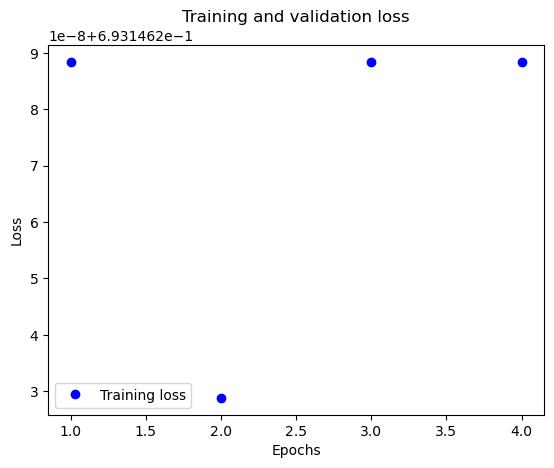

In [ ]:
# plot the training and validation loss
import matplotlib.pyplot as plt

loss_cnn_ensemble = history_cnn_ensemble.history['loss']
val_loss_cnn_ensemble = history_cnn_ensemble.history['val_loss']

epochs = range(1, len(loss_cnn_ensemble) + 1)

plt.plot(epochs, loss_cnn_ensemble, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

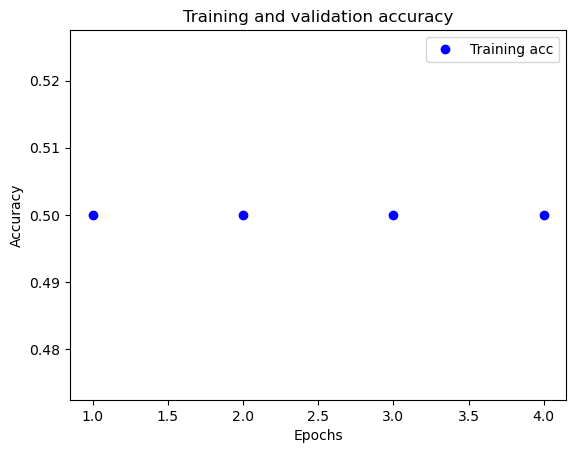

In [ ]:
# plot the training and validation accuracy
plt.clf()
plt.plot(epochs, history_cnn_ensemble.history['acc'], 'bo', label='Training acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

save models and model weights

In [ ]:
import pickle

# save model_cnn
with open('model_cnn.pkl', 'wb') as f:
    pickle.dump(model_cnn, f)
    
model_cnn.save_weights('model_weight_cnn.h5')

# save model_resnet_50
with open('model_resnet_50.pkl', 'wb') as f:
    pickle.dump(model_50, f)

model_50.save_weights('model_weight_resnet_50.h5')

# save model_resnet_101
with open('model_resnet_101.pkl', 'wb') as f:
    pickle.dump(model_101, f)

model_101.save_weights('model_weight_resnet_101.h5')

# save model_resnet_152
with open('model_resnet_152.pkl', 'wb') as f:
    pickle.dump(model_152, f)

model_152.save_weights('model_weight_resnet_152.h5')

# save model_vit
with open('model_vit.pkl', 'wb') as f:
    pickle.dump(vit_model, f)
    
vit_model.save_weights('model_weight_vit.h5')

# save model_cnn_ensemble
with open('model_cnn_ensemble.pkl', 'wb') as f:
    pickle.dump(model_cnn_ensemble, f)

model_cnn_ensemble.save_weights('model_weight_cnn_ensemble.h5')
